In [32]:
from rmssd_python_file import rmssd_labeled


## Extract attitude from PsychoPy trial CSVs

In [33]:
import pandas as pd
from glob import glob
import os

attitudes = {}

for path in glob("trials/*_manipulation-of-belief_*.csv"):
    df = pd.read_csv(path)

    # Get participant ID from filename
    # Example filename: "1_manipulation-of-belief_2025-11-12_14h45.39.812.csv"
    filename = os.path.basename(path)
    pid = int(filename.split("_")[0])

    # Extract attitude rating (first non-NaN opinion_slider.response)
    attitude = df["opinion_slider.response"].dropna().iloc[0]

    attitudes[pid] = attitude

print("Attitudes dict:", attitudes)


Attitudes dict: {10: 4.0, 11: 3.0, 12: 5.0, 13: 4.0, 14: 3.0, 15: 4.0, 16: 4.0, 17: 4.0, 18: 3.0, 19: 2.0, 1: 2.0, 20: 4.0, 21: 3.0, 22: 2.0, 23: 4.0, 2: 4.0, 3: 3.0, 4: 2.0, 5: 1.0, 6: 3.0, 7: 1.0, 8: 2.0}


In [34]:
rmssd_labeled["attitude_AI"] = rmssd_labeled["participant_id"].map(attitudes)


## Prepare data for GLMM

In [35]:
glmm_df = rmssd_labeled.copy()

# Standardize labels
glmm_df["belief_label"] = glmm_df["belief"].str.strip()

# Convert belief to binary predictor (optional, easier for GLMM)
glmm_df["assumed_AI"] = (glmm_df["belief_label"] == "AI Generated").astype(int)

# Drop rows with missing RMSSD
glmm_df = glmm_df.dropna(subset=["RMSSD_ms", "attitude_AI"])

glmm_df.head()


,participant_id,stim_id,video_id,belief,RMSSD_ms,RMSSD_seconds,attitude_AI,belief_label,assumed_AI
0,1,1,4171487-uhd_3840_2160_30fps.mp4,Human Generated,6.574545,0.006575,2.0,Human Generated,0
1,1,2,5768645-uhd_3840_2160_25fps.mp4,Human Generated,3.438652,0.003439,2.0,Human Generated,0
2,1,3,18840567-hd_1920_1080_30fps.mp4,AI Generated,9.997244,0.009997,2.0,AI Generated,1
3,1,4,11946387_3840_2160_30fps.mp4,AI Generated,11.292927,0.011293,2.0,AI Generated,1
4,2,1,4171487-uhd_3840_2160_30fps.mp4,Human Generated,9.658932,0.009659,4.0,Human Generated,0


## Fit a GLMM

In [36]:
import statsmodels.formula.api as smf

model = smf.mixedlm(
    "RMSSD_ms ~ assumed_AI + attitude_AI + assumed_AI:attitude_AI",
    data=glmm_df,
    groups=glmm_df["participant_id"],
)
result = model.fit()
print(result.summary())



               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     RMSSD_ms 
No. Observations:     88          Method:                 REML     
No. Groups:           22          Scale:                  119.5791 
Min. group size:      4           Log-Likelihood:         -359.0851
Max. group size:      4           Converged:              Yes      
Mean group size:      4.0                                          
-------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-------------------------------------------------------------------
Intercept               53.887   17.232  3.127 0.002  20.114 87.661
assumed_AI              -6.248    7.063 -0.885 0.376 -20.090  7.595
attitude_AI             -5.365    5.341 -1.005 0.315 -15.833  5.103
assumed_AI:attitude_AI   1.853    2.189  0.847 0.397  -2.437  6.144
Group Var              652.060   22.592                        

#### Labeling a video as AI vs Human did not significantly affect RMSSD, nor did attitudes toward AI, nor their interaction.

## Test

In [37]:
import pandas as pd
import numpy as np

# Drop rows with missing data
glmm_data = glmm_df.dropna(subset=["RMSSD_ms", "assumed_AI", "attitude_AI", "participant_id"]).copy()

# (Optional) center attitude for nicer interpretation
glmm_data["attitude_c"] = glmm_data["attitude_AI"] - glmm_data["attitude_AI"].mean()


In [38]:
import statsmodels.api as sm

data.exog = sm.add_constant(data.exog)

# Instantiate a gamma family model with the default link function.
gamma_model = sm.GLM(data.endog, data.exog, family=sm.families.Gamma())

gamma_results = gamma_model.fit()

print(gamma_results.summary())

ImportError: cannot import name '_center' from 'numpy.core._multiarray_umath' (c:\Users\jasmi\anaconda3\envs\ActiveML\Lib\site-packages\numpy\core\_multiarray_umath.cp311-win_amd64.pyd)

## Mean RMSSD by Assumed Label (AI-labeled vs Human-labeled)

C:\Users\jasmi\AppData\Local\Temp\ipykernel_20168\3124528653.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(
C:\Users\jasmi\AppData\Local\Temp\ipykernel_20168\3124528653.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


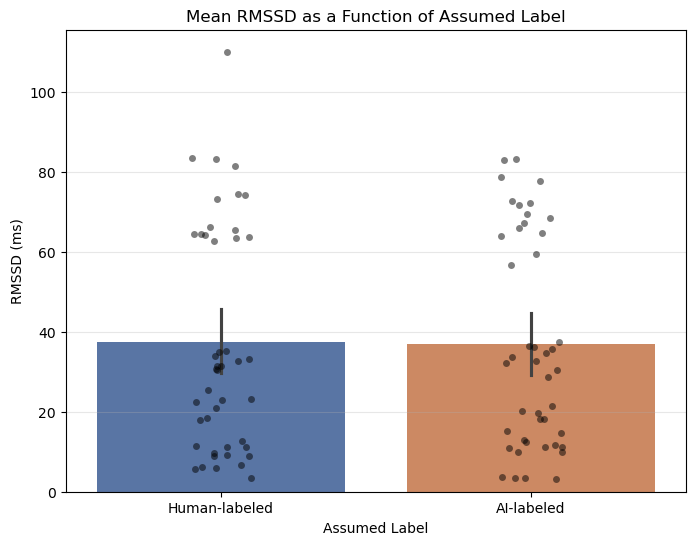

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

sns.barplot(
    data=glmm_df,
    x="assumed_AI",
    y="RMSSD_ms",
    estimator="mean",
    ci=95,
    palette=["#4C72B0", "#DD8452"],
)

sns.stripplot(
    data=glmm_df,
    x="assumed_AI",
    y="RMSSD_ms",
    color="black",
    alpha=0.5,
    jitter=0.1
)

plt.xticks([0, 1], ["Human-labeled", "AI-labeled"])
plt.xlabel("Assumed Label")
plt.ylabel("RMSSD (ms)")
plt.title("Mean RMSSD as a Function of Assumed Label")
plt.grid(axis="y", alpha=0.3)

plt.show()


## Code for a modeled marginal interaction plot

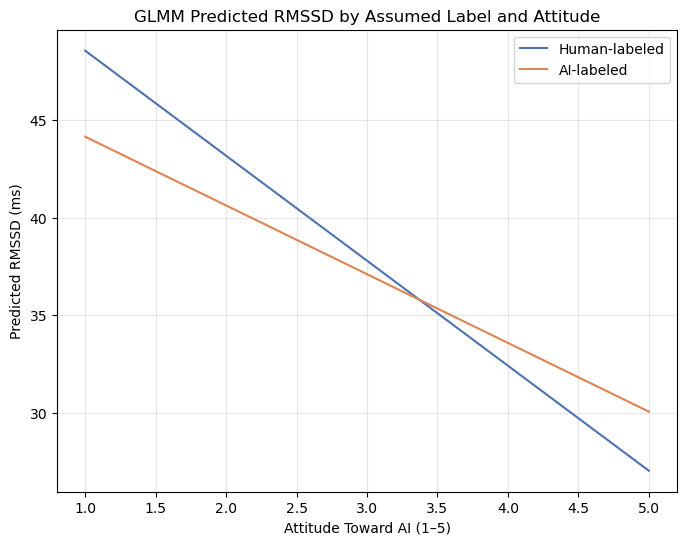

In [ ]:
import numpy as np

# Create prediction grid
att_vals = np.linspace(glmm_df["attitude_AI"].min(),
                       glmm_df["attitude_AI"].max(), 100)
pred_df = pd.DataFrame({
    "attitude_AI": att_vals,
    "assumed_AI": 0
})
pred_df2 = pred_df.copy()
pred_df2["assumed_AI"] = 1

# Predict from model
pred_df["RMSSD_pred"] = result.predict(pred_df)
pred_df2["RMSSD_pred"] = result.predict(pred_df2)

plt.figure(figsize=(8,6))
plt.plot(pred_df["attitude_AI"], pred_df["RMSSD_pred"], label="Human-labeled", color="#4C72B0")
plt.plot(pred_df2["attitude_AI"], pred_df2["RMSSD_pred"], label="AI-labeled", color="#DD8452")
plt.xlabel("Attitude Toward AI (1–5)")
plt.ylabel("Predicted RMSSD (ms)")
plt.title("GLMM Predicted RMSSD by Assumed Label and Attitude")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## 95% Confidence Intervals for the GLMM estimates

In [ ]:
ci = result.conf_int()
ci.columns = ["CI_lower", "CI_upper"]
ci


,CI_lower,CI_upper
Intercept,20.113899,87.660533
assumed_AI,-20.089833,7.594707
attitude_AI,-15.833199,5.102975
assumed_AI:attitude_AI,-2.437248,6.143614
Group Var,1.403786,9.502130
